In [1]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
import os

In [2]:
# Определение директорий с данными
drive.mount('/content/drive/')
path = '/content/drive/My Drive/Job/TestTaskMacroscop/'
train_dir = os.path.join(path, 'train_data')
validation_dir = os.path.join(path, 'test_data')

# Иницализация некоторых констант
BATCH_SIZE = 50
IMG_SHAPE  = 96 

Mounted at /content/drive/


In [10]:
# Функция для предобработки изображения
def preprocess(x):
    return (x - 127.5) / 128

# Инициализация генератора для тренировочной выборки
image_gen_train = ImageDataGenerator(preprocessing_function=preprocess,
                                     horizontal_flip=True)
train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE, IMG_SHAPE),
                                                     class_mode='binary')

# Инициализация генератора для валидационной выборки
validation_image_generator = ImageDataGenerator(preprocessing_function=preprocess)  
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE),
                                                              class_mode='binary')

Found 491 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [4]:
# Загрузка модели архитектуры MobileNetV2, натренированной на данных imagenet
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SHAPE, IMG_SHAPE, 3),
                                               include_top=False,
                                               weights='imagenet')
# Заморозка весов модели
base_model.trainable = False
base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
_________________

In [5]:
# Иницализация модели для обучения, состоящей из
# модели MobileNetV2, слоя GlobalAveragePooling2D и обычного полносвязного слоя.
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Компиляция модели
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [7]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [8]:
# Чекпоинт для сохранений лучших моделей
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path, 'checkpoints/checkpoint_acc-{val_accuracy}.hdf5'),
    monitor='val_accuracy',
    verbose=1, save_best_only=True, mode='max'
)

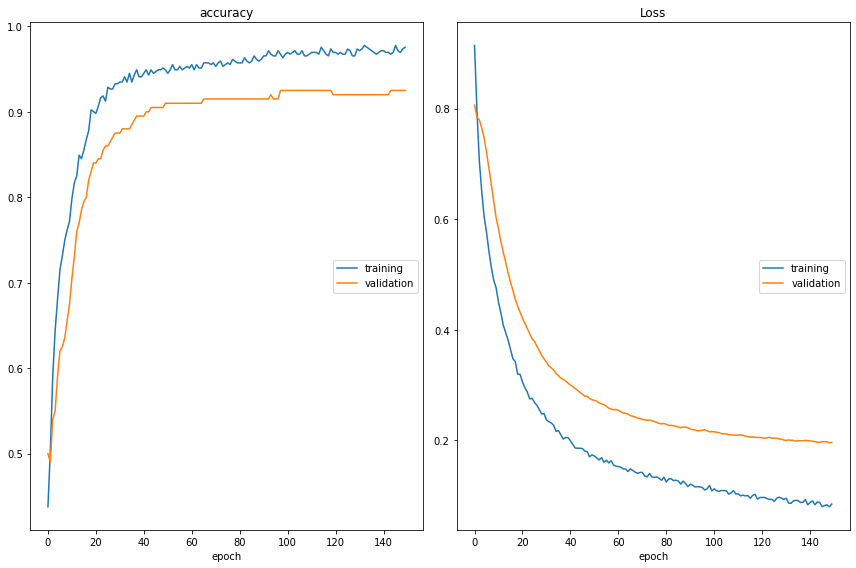

accuracy
	training         	 (min:    0.438, max:    0.978, cur:    0.976)
	validation       	 (min:    0.490, max:    0.925, cur:    0.925)
Loss
	training         	 (min:    0.080, max:    0.914, cur:    0.085)
	validation       	 (min:    0.196, max:    0.806, cur:    0.196)

Epoch 00150: val_accuracy did not improve from 0.92500


In [11]:
# Обучение модели
EPOCHS = 150
history = model.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback(), checkpoint])